# Notebook for developing diffrax/JAX based reconstruction package for XNH

In [36]:
import diffrax.functional as dx
from diffrax import LightField
from diffrax.utils import OpticalElement, OpticalLayer

import jax.numpy as jnp
from jax import random
import jax

from einops import rearrange, repeat
from einops import repeat, reduce
from flax.traverse_util import flatten_dict
from flax.core import unfreeze
import flax.linen as nn

from typing import Tuple
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Let's define some aspects of our system (based on CBxs_lobV_top_30nm at ESRF beamline i16a):

In [53]:
du = 0.03 # effective pixel size of detector (microns) (note: documented as pixelsize_detector = 3e-6 in ESRF script?)
z_total = 1.208 * 1000 # distance from focus point to detector (microns)
zs_f2s = jnp.array([0.012080, 0.012598, 0.014671, 0.018975]) * 1000 # distances source to sample (microns) 
zs_s2d = z_total - zs_f2s # distances sample to detector (microns) 
lambda_ =  7.25146e-5 # wavelength in microns for 17kEV (~3.62573e-05 um for 33kEV)
lambda_ratios = 1.0 # ratio of wavelengths
n = 0.999999999 # refractive index of x-rays is slightly below unity according to ESRF
dz = 1. # depth of slice in microns

Get and display Siemens star test object (then make it into a phase object)

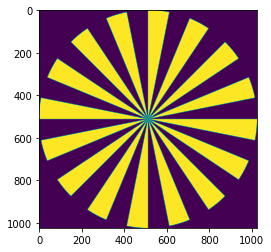

In [54]:
data = plt.imread('/n/groups/htem/users/jlr54/raygun/diffrax/Siemens_star.svg.png')
data = repeat(jnp.abs(jnp.mean(data, axis=-1)), 'h w -> b h w 1', b = zs_f2s.size) 
plt.imshow(data[0].squeeze())

In [55]:
# delta and beta should be 4d Tensors
deltas = data * 1.2600 # phase change
betas = data * 0.98200 # extinction

Now let's make the lightfields hitting the sample and display their intensity and phase:

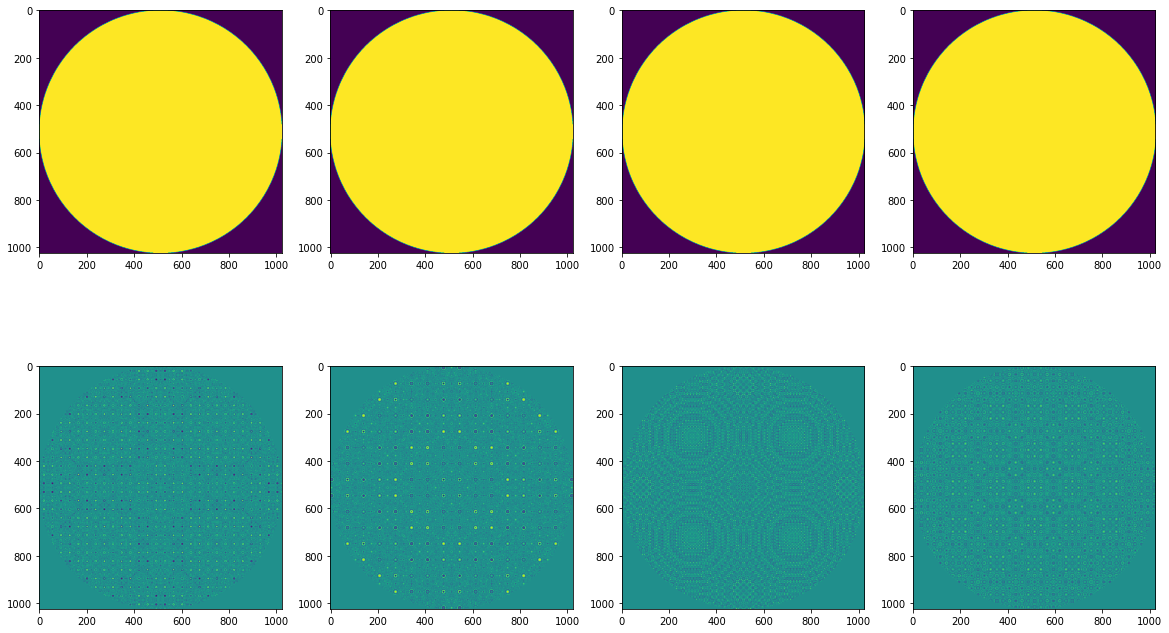

In [60]:
n_pixels = data.shape[1]
D = n_pixels * du
in_fields = [dx.pointsource((n_pixels, du), z0, D, n, lambda_, lambda_ratios) for z0 in zs_f2s]

def show_fields(fields):
    _, axs = plt.subplots(2, len(fields), figsize=(20, 3*len(fields)))
    for i, ax in enumerate(axs.T):
        ax[0].imshow(fields[i].intensity.squeeze())
        ax[1].imshow(fields[i].phase.squeeze())

show_fields(in_fields)

Now let's make some projections:

In [57]:
def phasechange_cache(field: LightField, delta: jnp.ndarray, beta: jnp.ndarray, dz: float) -> Tuple[jnp.ndarray]:
    k = 2 * jnp.pi / field.spectrum.wavelength
    phase_factor = jnp.exp(-1j * k * dz * (delta - 1j * beta))
    return (phase_factor,)


def phasechange_apply(field: LightField, cache: Tuple[jnp.ndarray]) -> LightField:
    (phase_factor,) = cache
    u = field.u * phase_factor
    return field.replace(u=u)

# Register as functions and layers:
phasechange = OpticalElement(phasechange_apply, phasechange_cache)
PhaseChange = OpticalLayer.init_layer("phase change", phasechange)

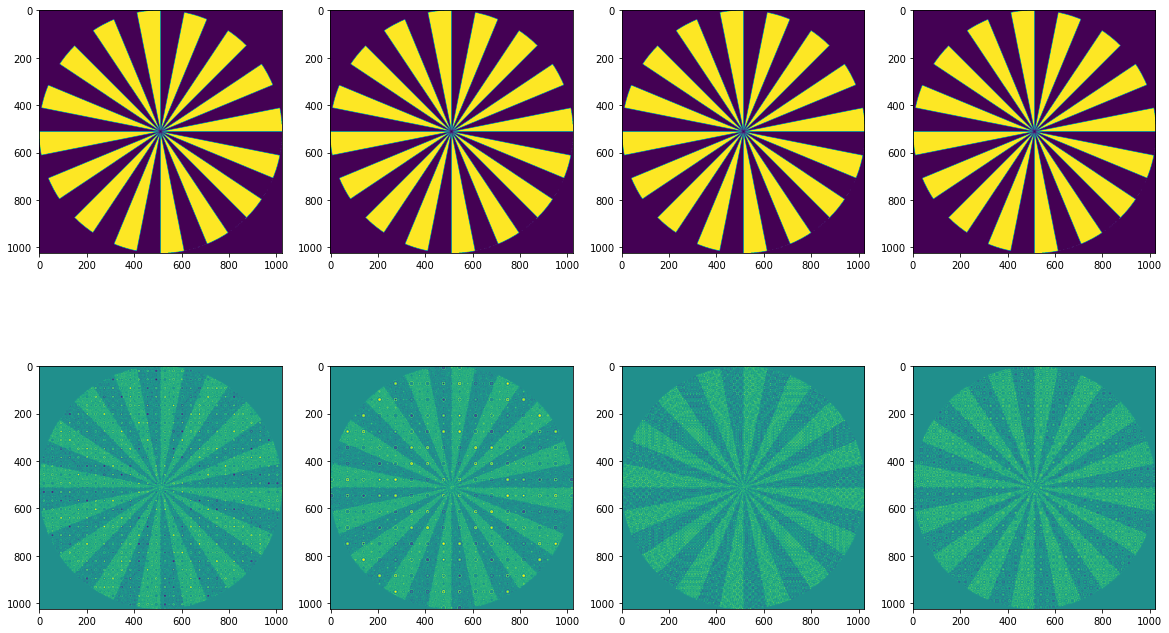

In [74]:
out_fields = [phasechange(in_field, delta, beta, dz=dz) for in_field, delta, beta in zip(in_fields, deltas, betas)]
show_fields(out_fields)

Let's add free space propagation after the sample:

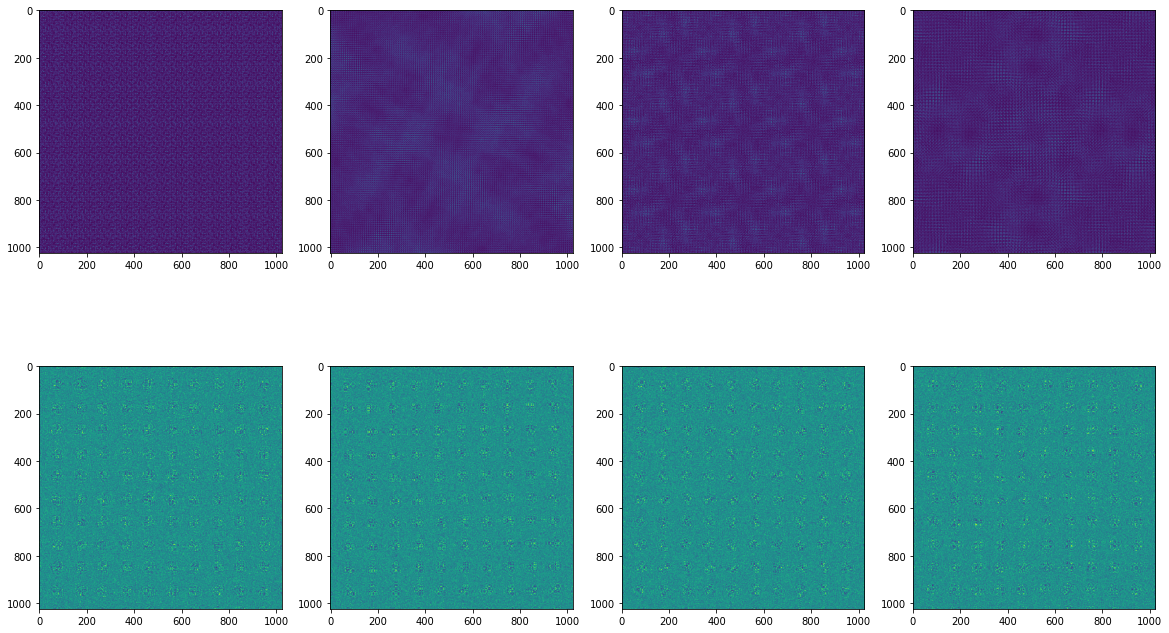

In [76]:
def propagate(field, dz, n, D): # here dz is distance to propogate wave
    Nf = jnp.max((D / 2) ** 2 / (field.spectrum.wavelength * dz))
    M = field.u.shape[1]
    Q = M / (4 * Nf)
    N = int(jnp.ceil((Q * M) / 2) * 2)
    N_pad = int((N - M) / 2)
    return dx.transform_propagate(field, z=dz, n=n, N_pad=1024)

sensor_fields = [propagate(in_field, z_s2d, n, D) for in_field, z_s2d in zip(out_fields, zs_s2d)]
sensor_images = [sensor_field.intensity for sensor_field in sensor_fields]
show_fields(sensor_fields)

### Now let's see if we can reconstruct the sample from the sensor images